# Objective: Autoregressive Linear Model Using Synthetic Sine Wave Data
Here, I'm going to build an autoregressive linear model using synthetic sine wave data for time series prediction.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Load Data
This covers how to create the original data.

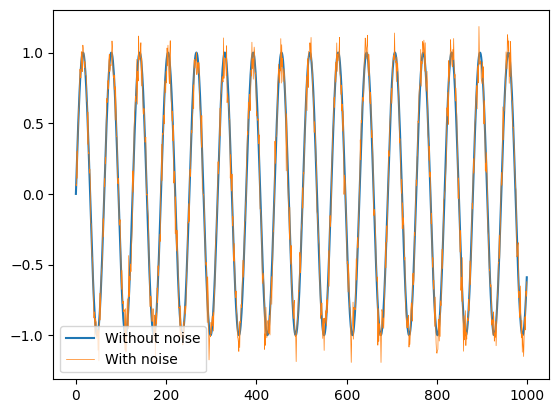

In [2]:
# make the original data
num_data = 1000
series = np.sin(0.1*np.arange(num_data))
series_noise = np.sin(0.1*np.arange(num_data)) + (0.1 * np.random.randn(num_data))

# plot the data
plt.plot(series, label='Without noise')
plt.plot(series_noise, label='With noise',
         linewidth=0.5)
plt.legend()
plt.show()

## Preprocess Data
This covers how to create dataset for training out of the original data.

In [3]:
# build the dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
    
# convert the data to numpy array and
# reshape the data for the model
X = np.array(X).reshape(-1, T)
N = len(X)
Y = np.array(Y).reshape(-1, 1)

# print out important parameters
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")
print(f"N: {N}, T: {T}, D: {D}")

X.shape: (990, 10), Y.shape: (990, 1)
N: 990, T: 10, D: 1


In [4]:
# split dataset into train set and test set
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[N//2:].astype(np.float32))

## Build Model
This covers how to build a autoregressive linear model for time series data synthetically created from sine wave.

In [5]:
# autoregressive linear model
model = nn.Linear(T, 1)

In [6]:
# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

## Training
This covers how to train the autoregressive linear model with the synthetic sine wave data that we processed.

In [7]:
# training
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    # losses will be stored to plot the results
    # storage for losses per each epoch
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        # zero the parameter gradients to make sure they are zero
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # backward and optimize
        loss.backward()
        optimizer.step()
        
        # save loss
        train_losses[epoch] = loss.item()
        
        ## test
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[epoch] = test_loss.item()
        
        # print out the result
        print(f"Epoch {epoch+1}/{epochs}, Train loss: {loss.item():.4f}, Test loss: {test_loss.item():.4f}")
        
    return train_losses, test_losses

In [8]:
# get the result
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 1/200, Train loss: 0.9691, Test loss: 0.1656
Epoch 2/200, Train loss: 0.1637, Test loss: 0.1884
Epoch 3/200, Train loss: 0.1912, Test loss: 0.4221
Epoch 4/200, Train loss: 0.4309, Test loss: 0.4085
Epoch 5/200, Train loss: 0.4174, Test loss: 0.2300
Epoch 6/200, Train loss: 0.2350, Test loss: 0.0715
Epoch 7/200, Train loss: 0.0726, Test loss: 0.0335
Epoch 8/200, Train loss: 0.0329, Test loss: 0.0977
Epoch 9/200, Train loss: 0.0976, Test loss: 0.1689
Epoch 10/200, Train loss: 0.1699, Test loss: 0.1743
Epoch 11/200, Train loss: 0.1756, Test loss: 0.1156
Epoch 12/200, Train loss: 0.1163, Test loss: 0.0422
Epoch 13/200, Train loss: 0.0424, Test loss: 0.0030
Epoch 14/200, Train loss: 0.0029, Test loss: 0.0138
Epoch 15/200, Train loss: 0.0141, Test loss: 0.0526
Epoch 16/200, Train loss: 0.0533, Test loss: 0.0813
Epoch 17/200, Train loss: 0.0821, Test loss: 0.0776
Epoch 18/200, Train loss: 0.0781, Test loss: 0.0480
Epoch 19/200, Train loss: 0.0480, Test loss: 0.0166
Epoch 20/200, Train l

## Result
This shows the result of the autoregressive linear model by showing the loss evolution.

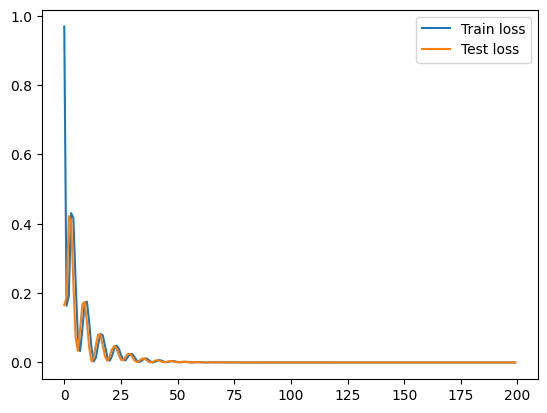

In [9]:
# plot the train loss and test loss per epoch
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

## Forecasting - Wrong Method
This is to show how to make wrong prediction by forecasting future values using true future values.

In [39]:
# wrong forecast using true future values
validation_targets = Y[N//2:]   # this is true targets
validation_predictions = []     # this stores predictions

# save predictions using true future values
i = 0
while len(validation_predictions) < len(validation_targets):
    input_ = X_test[i].reshape(1, -1)
    p = model(input_)[0, 0].item()
    i += 1
    # store the result in the container
    validation_predictions.append(p)

In [ ]:
# plot the results
plt.plot(validation_targets, label='Forecast targets',
         linestyle='-.')
plt.plot(validation_predictions, label='Forecast predictions',
         linewidth=0.5)
plt.legend()
plt.show()

The results are almost identical by just looking at them.

## Forecasting - Correct Method
This is to show how to make correct prediction by forecasting future values using future values from our prediction models.

In [10]:
# correct method to get future predictions using previous predictions
validation_targets = Y[N//2:]   # this is true targets
validation_predictions = []     # this is container to store predictions

# get the last train data
# which is cat([X_train[-1][1:], y_train[-1])
# this is same as X[-N//2]
last_X = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_targets):
    input_ = last_X.view(1, -1)
    p = model(input_)
    
    # store the result in the container
    validation_predictions.append(p[0, 0].item())
    # update the input including the prediction
    last_X = torch.cat((last_X[1:], p[0]))

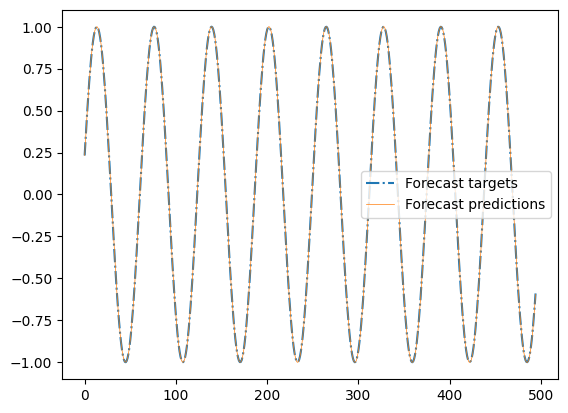

In [13]:
# plot the results
plt.plot(validation_targets, label='Forecast targets',
         linestyle='-.')
plt.plot(validation_predictions, label='Forecast predictions',
         linewidth=0.5)
plt.legend()
plt.show()